# Explanation:

This is the dataexploration notebook

# Setup

## Dependencies and plotting style

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import sklearn
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path

In [2]:
# Set global plot styles
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Dataloading part of the notebook

In [3]:
# Define the data path
DATA_PATH = Path("/Users/nikola/Python/KaggleCompetition/data")

# Load the new house transactions data
new_house_df = pd.read_csv(DATA_PATH / "train" / "new_house_transactions.csv")

setting year as index

In [4]:
# Convert to datetime
new_house_df['month'] = pd.to_datetime(new_house_df['month'], format='%Y-%b')

# Set year as index
new_house_df.index = new_house_df['month'].dt.year
new_house_df.index.name = 'year'

# # Keep only month name in the column
# new_house_df['month'] = new_house_df['month'].dt.strftime('%b')

# EXPLORATORY DATA ANALYSIS - Understanding the data
Scatterplot to see the distribution of the target variable = amount_new_house_transaction

## 1.1 Target Variable Analysis

NameError: name 'new_house' is not defined

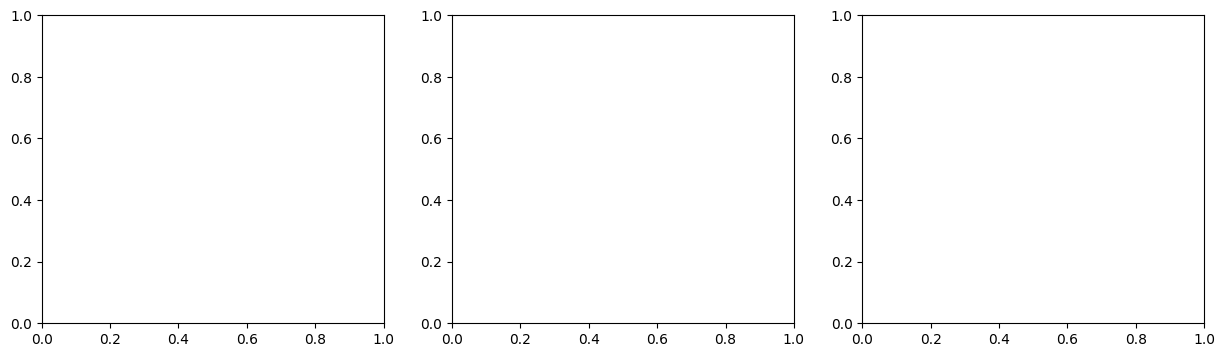

In [6]:
# Target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution
axes[0].hist(new_house['amount_new_house_transactions'].dropna(), bins=50, edgecolor='black')
axes[0].set_xlabel('Amount (10,000 yuan)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution')

# Log-transformed distribution
amount_log = np.log1p(new_house['amount_new_house_transactions'].dropna())
axes[1].hist(amount_log, bins=50, edgecolor='black')
axes[1].set_xlabel('Log(Amount + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Target Distribution')

# Boxplot for outliers
axes[2].boxplot(new_house['amount_new_house_transactions'].dropna())
axes[2].set_ylabel('Amount (10,000 yuan)')
axes[2].set_title('Target Outliers')

plt.tight_layout()
plt.show()

# Target statistics
print("Target Variable Statistics:")
print(new_house['amount_new_house_transactions'].describe())
print(f"\nMissing values: {new_house['amount_new_house_transactions'].isnull().sum()} ({new_house['amount_new_house_transactions'].isnull().sum()/len(new_house)*100:.2f}%)")
print(f"Zeros: {(new_house['amount_new_house_transactions'] == 0).sum()}")
print(f"Skewness: {new_house['amount_new_house_transactions'].skew():.2f}")

## 1.2 Temporal Patterns

In [ ]:
# Aggregate by month
monthly_stats = new_house.groupby('month').agg({
    'amount_new_house_transactions': ['sum', 'mean', 'median'],
    'sector': 'count'
}).round(2)

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Total amount over time
axes[0,0].plot(monthly_stats.index, monthly_stats['amount_new_house_transactions']['sum'])
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Total Amount (10,000 yuan)')
axes[0,0].set_title('Total Transaction Amount Over Time')
axes[0,0].grid(True, alpha=0.3)

# Average amount over time
axes[0,1].plot(monthly_stats.index, monthly_stats['amount_new_house_transactions']['mean'])
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Mean Amount (10,000 yuan)')
axes[0,1].set_title('Average Transaction Amount Over Time')
axes[0,1].grid(True, alpha=0.3)

# Number of sectors with transactions
axes[1,0].plot(monthly_stats.index, monthly_stats['sector']['count'])
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Number of Sectors')
axes[1,0].set_title('Active Sectors Over Time')
axes[1,0].grid(True, alpha=0.3)

# Seasonal pattern
new_house['month_num'] = new_house['month'].dt.month
monthly_pattern = new_house.groupby('month_num')['amount_new_house_transactions'].mean()
axes[1,1].bar(monthly_pattern.index, monthly_pattern.values)
axes[1,1].set_xlabel('Month of Year')
axes[1,1].set_ylabel('Average Amount')
axes[1,1].set_title('Seasonal Pattern')
axes[1,1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

## 1.3 Sector Analysis

In [ ]:
# Top sectors by total transaction amount
sector_stats = new_house.groupby('sector').agg({
    'amount_new_house_transactions': ['sum', 'mean', 'count']
}).round(2)
sector_stats.columns = ['total_amount', 'avg_amount', 'num_months']
sector_stats = sector_stats.sort_values('total_amount', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Top 20 sectors by total amount
top_20_sectors = sector_stats.head(20)
axes[0].barh(range(20), top_20_sectors['total_amount'].values)
axes[0].set_yticks(range(20))
axes[0].set_yticklabels(top_20_sectors.index, fontsize=8)
axes[0].set_xlabel('Total Amount (10,000 yuan)')
axes[0].set_title('Top 20 Sectors by Total Transaction Amount')
axes[0].invert_yaxis()

# Distribution of sectors by activity
axes[1].hist(sector_stats['num_months'], bins=30, edgecolor='black')
axes[1].set_xlabel('Number of Active Months')
axes[1].set_ylabel('Number of Sectors')
axes[1].set_title('Sector Activity Distribution')

plt.tight_layout()
plt.show()

print(f"Total sectors: {new_house['sector'].nunique()}")
print(f"Sectors with consistent activity (>90% months): {(sector_stats['num_months'] > sector_stats['num_months'].max()*0.9).sum()}")
print(f"Sectors with sparse activity (<10% months): {(sector_stats['num_months'] < sector_stats['num_months'].max()*0.1).sum()}")



## 1.4 Correlation Analysis

In [ ]:
# Correlation between numerical features in new_house
numeric_cols = new_house.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'amount_new_house_transactions']

if len(numeric_cols) > 0:
    correlations = new_house[numeric_cols + ['amount_new_house_transactions']].corr()['amount_new_house_transactions'].sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    correlations[1:].plot(kind='barh')
    plt.xlabel('Correlation with Target')
    plt.title('Feature Correlations with Target Variable')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("Top correlations with target:")
    print(correlations[1:6])

## 1.5 Missing Values Analysis

In [ ]:
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)

# For each dataset, show missing values per column
for name, df in datasets.items():
    print(f"\n{name.upper()}:")
    print("-"*40)
    
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = missing_count / len(df) * 100
        if missing_count > 0:
            print(f"{col}: {missing_count} ({missing_pct:.2f}%)")
    
    # If no missing values in dataset
    if df.isnull().sum().sum() == 0:
        print("No missing values")